<a href="https://colab.research.google.com/github/kavinraj-95/meme-analysis/blob/main/23CSE351_CS_23329.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install praw nltk networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from collections import Counter
import re
import nltk
import os
from nltk.sentiment import SentimentIntensityAnalyzer
import praw
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

# ---------------------------------------------------- Setup ----------------------------------------------------
nltk.download("vader_lexicon", quiet=True)
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

POSTS_PATH = os.path.join(results_dir, "distracted_boyfriend_posts.csv")
TEXT_PATH = os.path.join(results_dir, "distracted_boyfriend_text.csv")
TIME_SERIES_PATH = os.path.join(results_dir, "distracted_boyfriend_timeseries.csv")
SOCIAL_NW_PATH = os.path.join(results_dir, "distracted_boyfriend_network.gexf")
MASTER_PATH = os.path.join(results_dir, "meme_master_dataset.csv")

# NOTE: You must provide your own Reddit API credentials.
# These variables should be set in Colab secrets or directly here for a single run.
# Fill in your values below.
# CLIENT_ID = "YOUR_CLIENT_ID"
# CLIENT_SECRET = "YOUR_CLIENT_SECRET"
# USER_AGENT = "YOUR_USER_AGENT"

# Retrieve credentials from Colab secrets
try:
    CLIENT_ID = userdata.get('REDDIT_CLIENT_ID')
    CLIENT_SECRET = userdata.get('REDDIT_CLIENT_SECRET')
    USER_AGENT = True
except userdata.SecretNotFoundError as e:
    print(f"Error: {e}. Please make sure you have added your Reddit API credentials to Colab secrets.")
    print("Go to the '🔑' icon in the left sidebar and add secrets named 'REDDIT_CLIENT_ID', 'REDDIT_CLIENT_SECRET', and 'REDDIT_USER_AGENT'.")

    CLIENT_ID = None
    CLIENT_SECRET = None
    USER_AGENT = None


# ---------------------------------------- Web Scraping ----------------------------------------------------
def scrape_distracted_boyfriend(client_id, client_secret, user_agent, limit=200):
    """
    Scrapes posts related to 'Distracted Boyfriend' from the memes subreddit.
    """
    if not client_id or not client_secret or not user_agent:
        print("Reddit API credentials are not set. Skipping scraping.")
        return pd.DataFrame()

    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

    subreddit = reddit.subreddit("memes")
    query = "Distracted Boyfriend"
    posts = []

    print("🔹 Scraping Reddit posts...")
    for submission in subreddit.search(query, limit=limit):
        posts.append({
            "id": submission.id,
            "title": submission.title,
            "score": submission.score,
            "created_utc": submission.created_utc,
            "num_comments": submission.num_comments,
            "url": submission.url,
            "author": str(submission.author),
        })

    return pd.DataFrame(posts)

# ------------------------------------------------ Text Analysis ------------------------------------------
def analyze_text(input_df):
    df = input_df.copy()
    sia = SentimentIntensityAnalyzer()
    stop_words = set(stopwords.words("english"))

    df["clean_title"] = df["title"].apply(
        lambda x: " ".join(
            [w.lower() for w in re.findall(r"\b\w+\b", str(x)) if w.lower() not in stop_words]
        )
    )
    df["sentiment"] = df["clean_title"].apply(lambda x: sia.polarity_scores(x)["compound"])

    all_tokens = " ".join(df["clean_title"]).split()
    word_freq = Counter(all_tokens).most_common(20)

    return df, word_freq

# ---------------------------------------------------- Time Series Analysis --------------------------------
def time_series_analysis(input_df):
    """
    Aggregates data by date and generates time series plots.
    """
    df = input_df.copy()
    df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s")

    daily = df.groupby(df["created_dt"].dt.date).agg(
        avg_score=("score", "mean"),
        post_count=("id", "count"),
        avg_sentiment=("sentiment", "mean")
    ).reset_index()

    daily.rename(columns={"created_dt": "date"}, inplace=True)
    daily.to_csv(TIME_SERIES_PATH, index=False)
    print(f"✅ Saved time series results to {TIME_SERIES_PATH}")

    # ---- Visualization 1: Number of posts per day ----
    plt.figure(figsize=(12, 6))
    plt.plot(daily["date"], daily["post_count"], label="Number of Posts per Day")
    plt.title("'Distracted Boyfriend' Meme: Posts per Day")
    plt.xlabel("Date")
    plt.ylabel("Number of Posts")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    SERIES_PNG_PATH = os.path.join(results_dir, "time_series_posts.png")
    plt.savefig(SERIES_PNG_PATH, bbox_inches="tight")
    plt.close()

    # ---- Visualization 2: Average sentiment score ----
    plt.figure(figsize=(12, 6))
    plt.plot(daily["date"], daily["avg_sentiment"], label="Average Sentiment Score",
             linestyle="--", color="orange")
    plt.title("'Distracted Boyfriend' Meme: Average Sentiment Over Time")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    SENTIMENT_PNG_PATH = os.path.join(results_dir, "time_series_sentiment.png")
    plt.savefig(SENTIMENT_PNG_PATH, bbox_inches="tight")
    plt.close()

    return daily

# ---------------------------------------------------- Social Network Analysis ------------------------------------
def build_social_graph(client_id, client_secret, user_agent, input_df, max_comments=50):
    """
    Builds a directed graph of user interactions from post comments.
    """
    if not client_id or not client_secret or not user_agent:
        print("Reddit API credentials are not set. Skipping social graph analysis.")
        return None

    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

    graph = nx.DiGraph()
    print("🔹 Building social network graph...")

    for _, row in input_df.iterrows():
        submission = reddit.submission(id=row["id"])
        submission.comments.replace_more(limit=0)

        for comment in submission.comments[:max_comments]:
            if comment.author and row["author"] and comment.author.name != row["author"]:
                graph.add_edge(comment.author.name, row["author"])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15, iterations=20)

    node_degrees = dict(graph.degree())
    node_sizes = [v * 100 for v in node_degrees.values()]

    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(graph, pos, alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=8)

    plt.title("Social Network of Reddit Users Commenting on 'Distracted Boyfriend' Meme Posts")
    plt.xlabel("Users")
    plt.ylabel("Connections")

    GRAPH_PATH = os.path.join(results_dir, "social_graph.png")
    plt.savefig(GRAPH_PATH)
    plt.close()

    nx.write_gexf(graph, SOCIAL_NW_PATH)
    print(f"✅ Saved social network graph to {SOCIAL_NW_PATH}")
    return graph

# ---------------------------------------------------- Main Execution ----------------------------------------------------
def main():
    if not CLIENT_ID or not CLIENT_SECRET or not USER_AGENT:
        print("Cannot proceed without Reddit API credentials.")
        return

    # 1. Web Scraping
    df_posts = scrape_distracted_boyfriend(CLIENT_ID, CLIENT_SECRET, USER_AGENT)

    if df_posts.empty:
        print("No posts scraped. Cannot proceed with analysis.")
        return

    df_posts.to_csv(POSTS_PATH, index=False)
    print(f"✅ Saved posts data to {POSTS_PATH}")

    # 2. Text Analysis
    print("🔹 Running text analysis...")
    df_text, freq = analyze_text(df_posts)
    print("Top Words:", freq[:10])
    df_text.to_csv(TEXT_PATH, index=False)
    print(f"✅ Saved text analysis results to {TEXT_PATH}")

    # 3. Time Series Analysis
    print("🔹 Running time series analysis...")
    df_time = time_series_analysis(df_text)

    # 4. Social Network Analysis
    print("🔹 Building social network graph...")
    try:
        graph = build_social_graph(CLIENT_ID, CLIENT_SECRET, USER_AGENT, df_posts)
    except Exception as e:
        print(f"❌ Failed to build social graph: {e}")
        graph = None

    # 5. Combine All Results into One Master CSV
    print("🔹 Creating combined dataset...")
    posts_df = pd.read_csv(POSTS_PATH)
    text_df = pd.read_csv(TEXT_PATH)

    if os.path.exists(TIME_SERIES_PATH):
        time_df = pd.read_csv(TIME_SERIES_PATH)
    else:
        print(f"Warning: {TIME_SERIES_PATH} not found. Skipping merge with time series data.")
        time_df = pd.DataFrame()


    posts_df["created_dt"] = pd.to_datetime(posts_df["created_utc"], unit="s").dt.date
    text_df["created_dt"] = pd.to_datetime(text_df["created_utc"], unit="s").dt.date

    combined = posts_df.merge(text_df, on="id", suffixes=("_post", "_text"))

    if not time_df.empty:
        time_df["date"] = pd.to_datetime(time_df["date"]).dt.date
        combined = combined.merge(time_df, left_on="created_dt_post", right_on="date", how="left")

    combined.to_csv(MASTER_PATH, index=False)
    print(f"✅ Saved master dataset to {MASTER_PATH}")
    print("🎉 Pipeline completed successfully!")

if __name__ == "__main__":
    print("Starting Main..")
    main()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Starting Main..
🔹 Scraping Reddit posts...
✅ Saved posts data to ./results/distracted_boyfriend_posts.csv
🔹 Running text analysis...
Top Words: [('distracted', 63), ('boyfriend', 61), ('meme', 29), ('new', 6), ('2', 5), ('format', 4), ('found', 3), ('original', 3), ('saga', 3), ('version', 3)]
✅ Saved text analysis results to ./results/distracted_boyfriend_text.csv
🔹 Running time series analysis...
✅ Saved time series results to ./results/distracted_boyfriend_timeseries.csv


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



🔹 Building social network graph...
🔹 Building social network graph...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

✅ Saved social network graph to ./results/distracted_boyfriend_network.gexf
🔹 Creating combined dataset...
✅ Saved master dataset to ./results/meme_master_dataset.csv
🎉 Pipeline completed successfully!


## Example Results: meme used: "Distracted Boyfriend
"
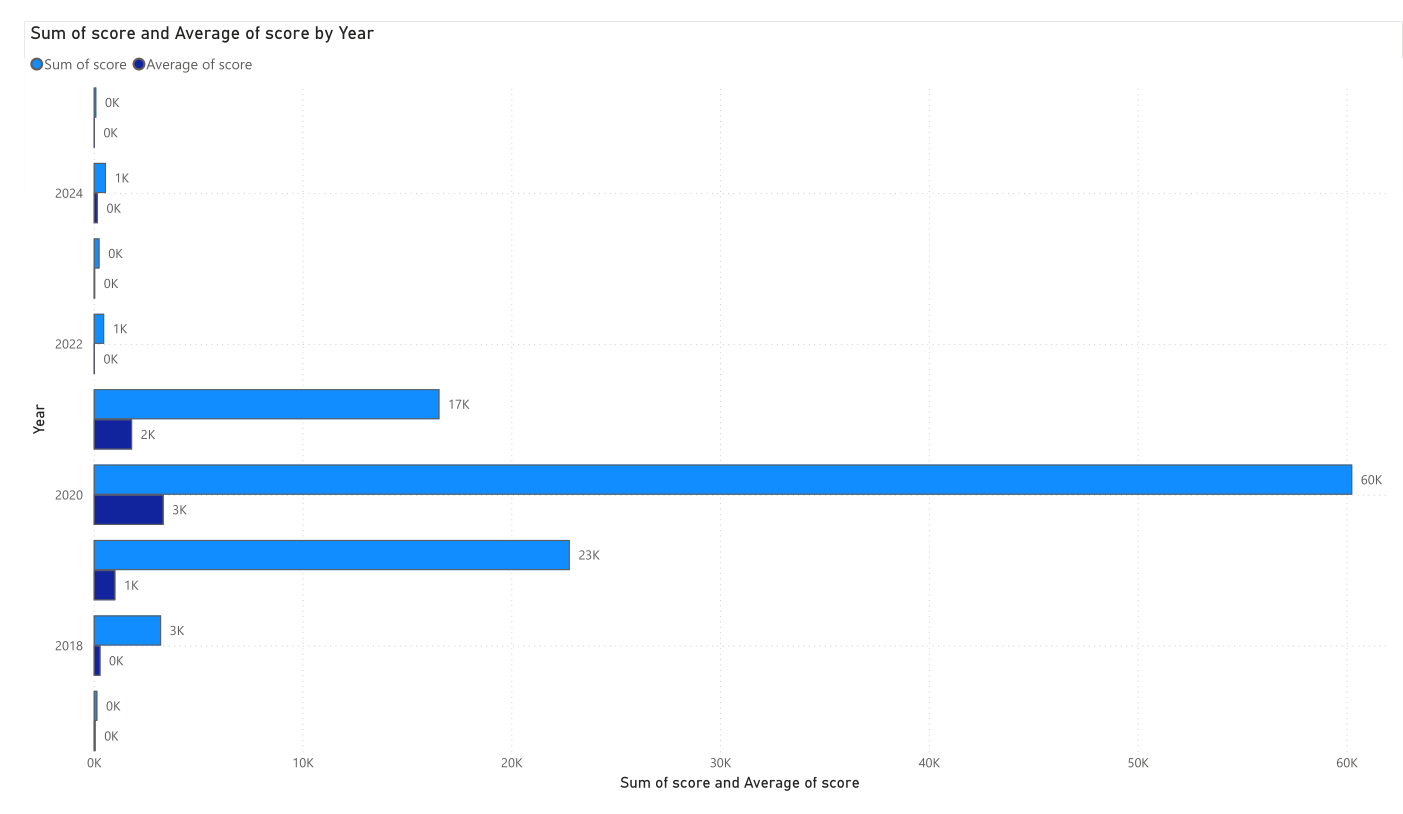

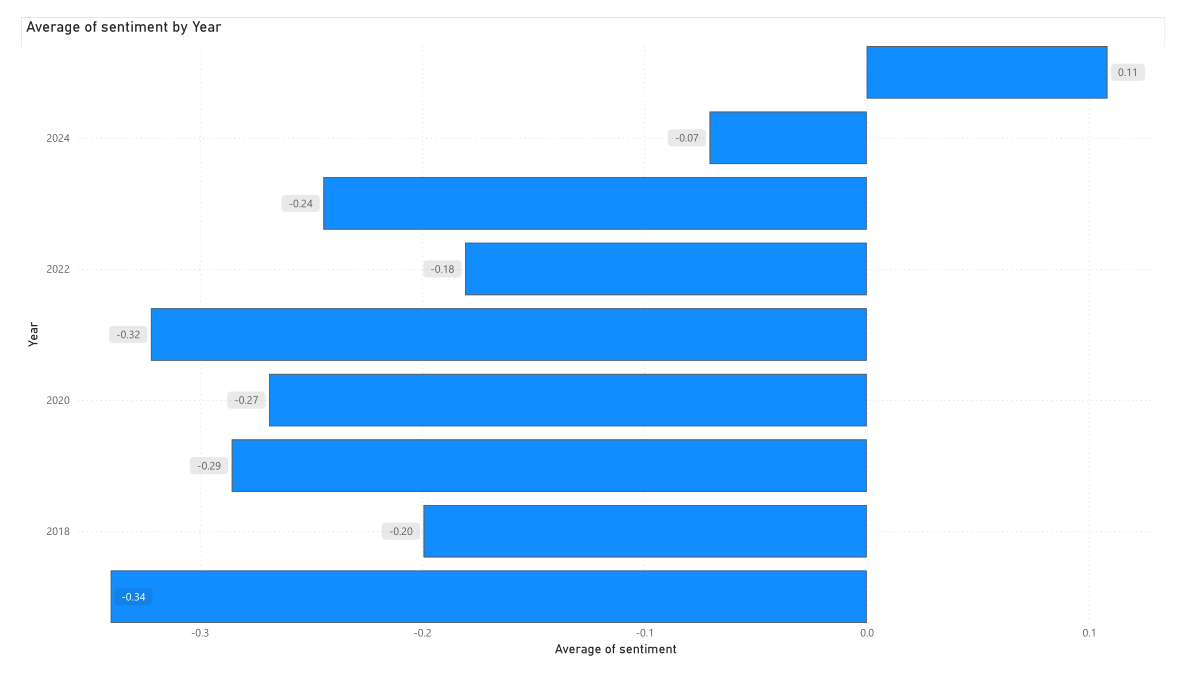

For more visualisations, change meme query and check ./results folder.

**Make sure you have added your Reddit API credentials to Colab secrets.**

1.  Click the "🔑" icon in the left sidebar.
2.  Add secrets with the following names and your corresponding Reddit API credentials:
    *   `REDDIT_CLIENT_ID`
    *   `REDDIT_CLIENT_SECRET`
    *   `REDDIT_USER_AGENT`